# Machine Learning on Histopathological Dataset for Breast Cancer
Dataset from [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

## Getting dataset from google drive


Uploaded dataset at [Google Drive](https://drive.google.com/open?id=18YKz4OtbmQ0hZC67lOcoJ4mxR1liT4hu)

### Mounting Google drive

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extracting data from drive

In [0]:
import zipfile

zip_dir = '/content/drive/My Drive/Datasets/histopathologic-cancer-detection.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/tmp/histo/')
zip_ref.close()

KeyboardInterrupt: ignored

### Rearranging data and directories


In [0]:
train_zip_dir = '/tmp/histo/train.zip'
test_zip_dir = '/tmp/histo/test.zip'

train_zip_ref = zipfile.ZipFile(train_zip_dir, 'r')
train_zip_ref.extractall('/tmp/histo/train/')
train_zip_ref.close()

test_zip_ref = zipfile.ZipFile(test_zip_dir, 'r')
test_zip_ref.extractall('/tmp/histo/test/')
test_zip_ref.close()

In [0]:
!rm /tmp/histo/test.zip
!rm /tmp/histo/train.zip

Read the tabel of labelled filenames

In [0]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format

histo_dataframe = pd.read_csv('/tmp/histo/train_labels.csv')

histo_dataframe = histo_dataframe.reindex(
    np.random.permutation(histo_dataframe.index))
histo_dataframe

Getting split lengths for training data for 70-30 train-val splits

In [0]:
train_percentage = 70.0
total_len = len(histo_dataframe)
train_len = int(total_len * 0.7)
val_len = total_len - train_len

In [0]:
train_benign_names = list()
train_malignant_names = list()
for i in histo_dataframe.head(train_len).index:
  if (histo_dataframe['label'][i] == 0):
    train_benign_names.append(histo_dataframe['id'][i] + ".tif")
  else: 
    train_malignant_names.append(histo_dataframe['id'][i] + ".tif")


val_benign_names = list()
val_malignant_names = list()
for i in histo_dataframe.tail(val_len).index:
  if (histo_dataframe['label'][i] == 0):
    val_benign_names.append(histo_dataframe['id'][i] + ".tif")
  else: 
    val_malignant_names.append(histo_dataframe['id'][i] + ".tif")

move around the files in the right order

In [0]:
!mkdir /tmp/histo/train/train/
!mkdir /tmp/histo/train/train/benign/
!mkdir /tmp/histo/train/train/malignant/

!mkdir /tmp/histo/train/val/
!mkdir /tmp/histo/train/val/benign/
!mkdir /tmp/histo/train/val/malignant/

move data from extracted directory into designated directories

In [0]:
import os

base_dir = '/tmp/histo/train'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')

val_benign_dir = os.path.join(val_dir, 'benign')
val_malignant_dir = os.path.join(val_dir, 'malignant')

for fname in train_benign_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(train_benign_dir, fname))

for fname in train_malignant_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(train_malignant_dir, fname))

for fname in val_benign_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(val_benign_dir, fname))

for fname in val_malignant_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(val_malignant_dir, fname))

## Displaying some slices

In [0]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

images_per_class = 10

print("Benign")

plt.figure(figsize=(15,6))
for i in range(1, images_per_class + 1):
  plt.subplot(2, 5, i)
  plt.axis('off')
  selected_img = np.random.choice(os.listdir(val_benign_dir))
  plt.imshow(mpimg.imread(os.path.join(val_benign_dir, selected_img)))

plt.show()
print("Malignant")

plt.figure(figsize=(15,6))
for i in range(1, images_per_class + 1):
  plt.subplot(2, 5, i)
  plt.axis('off')
  selected_img = np.random.choice(os.listdir(val_malignant_dir))
  plt.imshow(mpimg.imread(os.path.join(val_malignant_dir, selected_img)))

## Preprocessing and Loading data

Creating data generators for easy augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add augmentation over here
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 30

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary')



In [0]:
def get_training_metrics(train_split_percentage, history, optimizer,learning_rate, steps_per_epoch, total_epochs, validation_steps, batch_size, print_table_header = False):
  """Gets the model metrics in a documentable format
  Args:
    train_split_percentage: `int` for the percentage of the dataset allocated to print
    model: `Model` object containing the trained model
    history: `History` object containing the training history
    optimzer: `optimizer` object for tensorflow used for optimization during training
    learning_rate: `float` for the learning rate
    steps_per_epoch: `int` for batches tried per one epoch
    total_epochs: `int` for total number of epochs
    batch_size: `int` for the images per batch
    print_table_header: `bool` indicating whether to print values along with the table header
  Returns:
    None
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  optimizer_name = 'SGD'
  print("copy the following text to your notebook text block: ")
  if(print_table_header):
    print(">Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate")
    print(">--- | --- | --- | --- | --- | --- | ---")
  print(">%02d-%02d | %02d | %02d | %02d | %02d | %s | %f " %
        (int(train_split_percentage), (100 - int(train_split_percentage)),
         batch_size,
         total_epochs,
         steps_per_epoch,
         validation_steps,
         optimizer_name,
         learning_rate))
  
  
  print(">$Loss_{train} =  %.4f$ | | $Loss_{val} = %.4f$ |  |$Accuracy_{train} = %.4f$ | |  $Accuracy_{val} = %.4f$" % 
        (loss[-1], 
         val_loss[-1], 
         acc[-1], 
         val_acc[-1]))

In [0]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, label="Training")
  plt.plot(epochs, val_acc, label="Validation")
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label="Training")
  plt.plot(epochs, val_loss, label="Validation")
  plt.title('Training and validation loss')
  plt.legend()


In [0]:
from keras import layers
from keras import Model
from keras.optimizers import Adagrad, SGD

# Standard (In Progress: Model tweaking)

## Building and compiling the architecture

In [0]:
img_input = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)

standard_model = Model(img_input, output)

standard_model.summary()

## Fitting data on the model

Fitting trials on rough CNN architecture: 

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 500 | 100 | Adagrad | 0.0001
>$Loss_{train} =  0.529$ | | $Loss_{val} = 8.325$ |  |$Accuracy_{train} = 0.741$ | |  $Accuracy_{val} = 0.456$
>70-30 | 30 | 30 | 500 | 250 | Adagrad | 0.0001
>$Loss_{train} =  0.546$ | | $Loss_{val} = 0.533$ |  |$Accuracy_{train} = 0.745$ | |  $Accuracy_{val} = 0.744$
>70-30 | 100 | 30 | 1600 | 250 | SGD | 0.0001
>$Loss_{train} =  9.1188$ | | $Loss_{val} = 0.4053$ |  |$Accuracy_{train} = 9.1340$ | |  $Accuracy_{val} = 0.4043$
>70-30 | 100 | 15 | 100 | 250 | ? | ? 
>$Loss_{train} =  0.629$ | | $Loss_{val} = 0.614$ |  |$Accuracy_{train} = 0.646$ | |  $Accuracy_{val} = 0.663$
>70-30 | 100 | E=20 | 100 | 600 | SGD | 0.0005
>$Loss_{train} =  0.554$ | | $Loss_{val} = 0.537$ |  |$Accuracy_{train} = 0.729$ | |  $Accuracy_{val} = 0.752$
>70-30 | 100 | 30 | 100 | 600 | SGD | 0.0001
>$Loss_{train} =  0.622$ | | $Loss_{val} = 0.613$ |  |$Accuracy_{train} = 0.636$ | |  $Accuracy_{val} = 0.605$

**Changing the architecture => Adding 2 more convolution and max pooling layers**

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 100 | 30 | 100 | 600 | SGD | 0.001
>$Loss_{train} =  0.5367$ | | $Loss_{val} = 0.5335$ |  |$Accuracy_{train} = 0.7540$ | |  $Accuracy_{val} = 0.7365$

**Changing the architecture => "Evolution"**

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 100 | 30 | 100 | 600 | SGD | 0.0001
>$Loss_{train} =  0.685$ | | $Loss_{val} = 0.686$ |  |$Accuracy_{train} = 0.601$ | |  $Accuracy_{val} = 0.596$
>70-30 | 100 | 30 | 150 | 600 | SGD | 0.0005
>$Loss_{train} =  0.672$ | | $Loss_{val} = 0.670$ |  |$Accuracy_{train} = 0.592$ | |  $Accuracy_{val} = 0.595$
>70-30 | 30 | 30 | 500 | 100 | Adagrad | 0.0001
>$Loss_{train} =  0.529$ | | $Loss_{val} = 8.325$ |  |$Accuracy_{train} = 0.741$ | |  $Accuracy_{val} = 0.456$
---






Using the following architecture for fitting:


- input_1 (InputLayer)         [(None, 100, 100, 3)]     0

- conv2d (Conv2D)              (None, 98, 98, 16)        448       
- max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0     
- conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640    
- max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
- conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496   
- max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
- conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
- max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0        
- conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168  
- max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0       
- flatten (Flatten)            (None, 256)               0         
- dense (Dense)                (None, 256)               65792     
- dense_1 (Dense)              (None, 256)               65792    
- dropout (Dropout)            (None, 256)               0         
- dense_2 (Dense)              (None, 1)                 257      

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6659$ | | $Loss_{val} = 0.6694$ |  |$Accuracy_{train} = 0.6100$ | |  $Accuracy_{val} = 0.5967$
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6733$ | | $Loss_{val} = 0.6681$ |  |$Accuracy_{train} = 0.5877$ | |  $Accuracy_{val} = 0.6007$

**Changing architecure**
- input_4 (InputLayer)         [(None, 100, 100, 3)]     0  
- conv2d_14 (Conv2D)           (None, 98, 98, 16)        448       
- max_pooling2d_14 (MaxPooling (None, 49, 49, 16)        0   
- conv2d_15 (Conv2D)           (None, 47, 47, 32)        4640      
- max_pooling2d_15 (MaxPooling (None, 23, 23, 32)        0 
- conv2d_16 (Conv2D)           (None, 21, 21, 64)        18496     
- max_pooling2d_16 (MaxPooling (None, 10, 10, 64)        0         
- conv2d_17 (Conv2D)           (None, 8, 8, 128)         73856     
- max_pooling2d_17 (MaxPooling (None, 4, 4, 128)         0 
- flatten_3 (Flatten)          (None, 2048)              0  
- dense_9 (Dense)              (None, 1024)              2098176   
- dense_10 (Dense)             (None, 512)               524800    
- dropout_3 (Dropout)          (None, 512)               0  
- dense_11 (Dense)             (None, 1)                 513       

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6038$ | | $Loss_{val} = 0.6039$ |  |$Accuracy_{train} = 0.6770$ | |  $Accuracy_{val} = 0.6743$
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6713$ | | $Loss_{val} = 0.6641$ |  |$Accuracy_{train} = 0.5863$ | |  $Accuracy_{val} = 0.5998$

In [0]:
learning_rate = 0.001
steps_per_epoch = 100
epochs = 20
validation_steps = 600
optimizer=SGD(lr=learning_rate)

In [0]:
standard_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['acc'])

history = standard_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)


In [0]:
plot_training(history)

# Inception-V3 (Feature Extraction from the pre-trained model)


In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

## Setting up pretrained model

### Loading the pre-defined model architecture

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(100, 100, 3),
    include_top=False,
    weights=None)
pre_trained_model.load_weights(local_weights_file)

## Freezing and customizing the architecture

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed4')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)

x = layers.Dense(256, activation='relu')(x)

x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

inception_model = Model(pre_trained_model.input, x)


## Fitting the data on the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 150 | 600 | SGD | 0.000100 
>$Loss_{train} =  0.5237$ | | $Loss_{val} = 0.5109$ |  |$Accuracy_{train} = 0.7516$ | |  $Accuracy_{val} = 0.7633$
>70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3810$ | | $Loss_{val} = 0.4379$ |  |$Accuracy_{train} = 0.8302$ | |  $Accuracy_{val} = 0.7969$
>70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3761$ | | $Loss_{val} = 0.3922$ |  |$Accuracy_{train} = 0.8367$ | |  $Accuracy_{val} = 0.8224$

### The Knobs and Toggles

In [0]:
learning_rate = 0.001
steps_per_epoch = 200
epochs = 30
validation_steps = 600
optimizer=SGD(lr=learning_rate)

In [0]:
inception_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = inception_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### History

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=False)

In [0]:
layer0 = inception_model.get_layer(index=130)
print(layer0.get_config())
layer0.get_weights()

In [0]:
plot_training(history)

# Inception-V3 (Retraining complete architecture)

## Setting up the model architecture

In [0]:
from keras.applications.inception_v3 import InceptionV3

predefined_model = InceptionV3(
    input_shape=(100,100,3),
    include_top=True,
    weights=None,
    classes=1)

## Fitting model on the data

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3498$ | | $Loss_{val} = 0.4528$ |  |$Accuracy_{train} = 0.8498$ | |  $Accuracy_{val} = 0.7849$
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3741$ | | $Loss_{val} = 9.5304$ |  |$Accuracy_{train} = 0.4120$ | |  $Accuracy_{val} = 0.4022$

Changing model initization using the API:

```python
predefined_model = InceptionV3(
    input_shape=(100, 100, 3),
    include_top=False,
    weights=None)
```
TO:
```python
predefined_model = InceptionV3(
    input_shape=(100,100,3),
    include_top=True,
    weights=None,
    classes=1)
```

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### Training results

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))

In [0]:
predefined_model.summary()

In [0]:
del predefined_model

# VGG-Net (Roughly copied architecture)

## Creating VGG-Net's architecture

In [0]:
img_input = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(64, 2, activation='relu')(img_input)
x = layers.Conv2D(64, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 2, activation='relu')(x)
x = layers.Conv2D(128, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(256, 2, activation='relu')(x)
x = layers.Conv2D(256, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)

output = layers.Dense(1, activation='sigmoid')(x)

vgg_model = Model(img_input, output)

vgg_model.summary()

## Fitting the data on the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6742$ | | $Loss_{val} = 0.6731$ |  |$Accuracy_{train} = 0.5970$ | |  $Accuracy_{val} = 0.5998$

In [0]:
learning_rate = 0.001
steps_per_epoch = 200
epochs = 30
validation_steps = 600
optimizer=SGD(lr=learning_rate)

In [0]:
vgg_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = vgg_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

#VGG16 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.vgg16 import VGG16

predefined_model = VGG16(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.5619$ | | $Loss_{val} = 9.4645$ |  |$Accuracy_{train} = 0.4002$ | |  $Accuracy_{val} = 0.4063$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### Training results

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#VGG19 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.vgg19 import VGG19

predefined_model = VGG19(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6646$ | | $Loss_{val} = 9.5123$ |  |$Accuracy_{train} = 0.3938$ | |  $Accuracy_{val} = 0.4033$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6646$ | | $Loss_{val} = 9.5123$ |  |$Accuracy_{train} = 0.3938$ | |  $Accuracy_{val} = 0.4033$


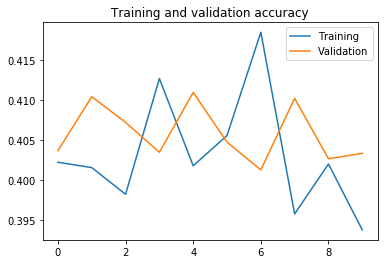

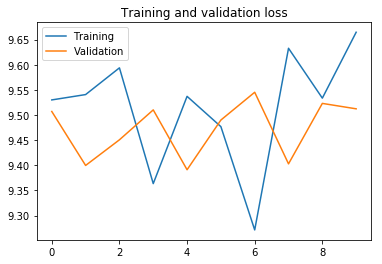

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

NameError: ignored

#ResNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.resnet import ResNet152

predefined_model = ResNet152(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7249$ | | $Loss_{val} = 9.4708$ |  |$Accuracy_{train} = 0.3900$ | |  $Accuracy_{val} = 0.4059$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 300s 2s/step - loss: 9.5690 - acc: 0.3998 - val_loss: 9.4506 - val_acc: 0.4072
Epoch 2/10
150/150 [==============================] - 226s 2s/step - loss: 9.5371 - acc: 0.4018 - val_loss: 9.4305 - val_acc: 0.4085
Epoch 3/10
150/150 [==============================] - 227s 2s/step - loss: 9.5052 - acc: 0.4038 - val_loss: 9.5006 - val_acc: 0.4041
Epoch 4/10
150/150 [==============================] - 228s 2s/step - loss: 9.4769 - acc: 0.4056 - val_loss: 9.4666 - val_acc: 0.4062
Epoch 5/10
150/150 [==============================] - 228s 2s/step - loss: 9.4981 - acc: 0.4042 - val_loss: 9.5231 - val_acc: 0.4027
Epoch 6/10
150/150 [==============================] - 230s 2s/step - loss: 9.3989 - acc: 0.4104 - val_loss: 9.4868 - val_acc: 0.4049
Epoch 7/10
150/150 [==============================] - 227s 2s/step - loss: 9.3600 - acc: 0.4129 - val_loss: 9.4974 - val_acc: 0.4043
Epoch 8/10
150/150 [==============================] - 230s 2s/step - 

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7249$ | | $Loss_{val} = 9.4708$ |  |$Accuracy_{train} = 0.3900$ | |  $Accuracy_{val} = 0.4059$


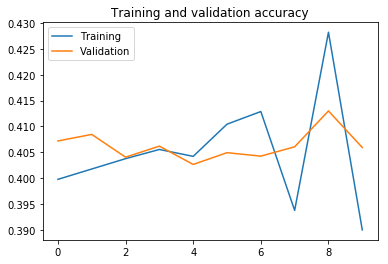

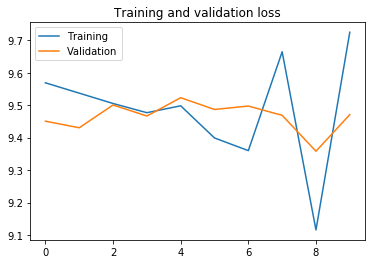

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#InceptionResNetV2 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

predefined_model = InceptionResNetV2(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 49, 49, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 49, 49, 32)   96          conv2d_208[0][0]                 
__________________________________________________________________________________________________
activation_392 (Activation)     (None, 49, 49, 32)   0           batch_normalization_208[0][0]    
________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7071$ | | $Loss_{val} = 9.4985$ |  |$Accuracy_{train} = 0.3911$ | |  $Accuracy_{val} = 0.4042$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 197s 1s/step - loss: 9.4839 - acc: 0.4051 - val_loss: 9.4570 - val_acc: 0.4068
Epoch 2/10
150/150 [==============================] - 140s 935ms/step - loss: 9.5548 - acc: 0.4007 - val_loss: 9.4581 - val_acc: 0.4067
Epoch 3/10
150/150 [==============================] - 140s 933ms/step - loss: 9.5052 - acc: 0.4038 - val_loss: 9.5229 - val_acc: 0.4027
Epoch 4/10
150/150 [==============================] - 140s 931ms/step - loss: 9.5158 - acc: 0.4031 - val_loss: 9.4379 - val_acc: 0.4080
Epoch 5/10
150/150 [==============================] - 140s 933ms/step - loss: 9.5123 - acc: 0.4033 - val_loss: 9.4688 - val_acc: 0.4061
Epoch 6/10
150/150 [==============================] - 140s 931ms/step - loss: 9.3600 - acc: 0.4129 - val_loss: 9.4049 - val_acc: 0.4101
Epoch 7/10
150/150 [==============================] - 140s 932ms/step - loss: 9.5371 - acc: 0.4018 - val_loss: 9.4326 - val_acc: 0.4083
Epoch 8/10
150/150 [==============================]

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7071$ | | $Loss_{val} = 9.4985$ |  |$Accuracy_{train} = 0.3911$ | |  $Accuracy_{val} = 0.4042$


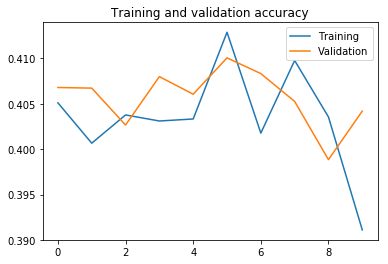

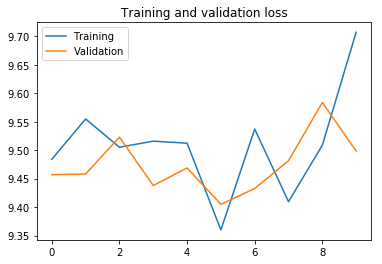

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#MobileNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.mobilenet import MobileNet

predefined_model = MobileNet(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "mobilenet_1.00_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32) 

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.1899$ | | $Loss_{val} = 9.3954$ |  |$Accuracy_{train} = 0.4236$ | |  $Accuracy_{val} = 0.4107$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 69s 463ms/step - loss: 9.2997 - acc: 0.4167 - val_loss: 9.5463 - val_acc: 0.4012
Epoch 2/10
150/150 [==============================] - 33s 218ms/step - loss: 9.3529 - acc: 0.4133 - val_loss: 9.4411 - val_acc: 0.4078
Epoch 3/10
150/150 [==============================] - 32s 216ms/step - loss: 9.4698 - acc: 0.4060 - val_loss: 9.4687 - val_acc: 0.4061
Epoch 4/10
150/150 [==============================] - 43s 289ms/step - loss: 9.6823 - acc: 0.3927 - val_loss: 9.3848 - val_acc: 0.4113
Epoch 5/10
150/150 [==============================] - 37s 250ms/step - loss: 9.4875 - acc: 0.4049 - val_loss: 9.5060 - val_acc: 0.4037
Epoch 6/10
150/150 [==============================] - 33s 219ms/step - loss: 9.5158 - acc: 0.4031 - val_loss: 9.4560 - val_acc: 0.4069
Epoch 7/10
150/150 [==============================] - 34s 227ms/step - loss: 9.4769 - acc: 0.4056 - val_loss: 9.5420 - val_acc: 0.4015
Epoch 8/10
150/150 [==============================] - 3

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.1899$ | | $Loss_{val} = 9.3954$ |  |$Accuracy_{train} = 0.4236$ | |  $Accuracy_{val} = 0.4107$


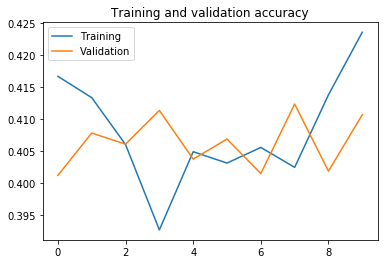

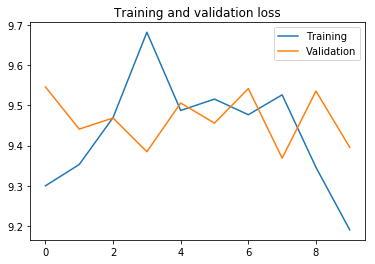

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#MobileNetV2 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2

predefined_model = MobileNetV2(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "mobilenetv2_1.00_100"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.4556$ | | $Loss_{val} = 9.4145$ |  |$Accuracy_{train} = 0.4069$ | |  $Accuracy_{val} = 0.4095$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 82s 544ms/step - loss: 9.4343 - acc: 0.4082 - val_loss: 9.4772 - val_acc: 0.4055
Epoch 2/10
150/150 [==============================] - 42s 283ms/step - loss: 9.4414 - acc: 0.4078 - val_loss: 9.4071 - val_acc: 0.4099
Epoch 3/10
150/150 [==============================] - 45s 297ms/step - loss: 9.6505 - acc: 0.3947 - val_loss: 9.4878 - val_acc: 0.4049
Epoch 4/10
150/150 [==============================] - 45s 297ms/step - loss: 9.4804 - acc: 0.4053 - val_loss: 9.4921 - val_acc: 0.4046
Epoch 5/10
150/150 [==============================] - 41s 274ms/step - loss: 9.5619 - acc: 0.4002 - val_loss: 9.4209 - val_acc: 0.4091
Epoch 6/10
150/150 [==============================] - 39s 258ms/step - loss: 9.5158 - acc: 0.4031 - val_loss: 9.4262 - val_acc: 0.4087
Epoch 7/10
150/150 [==============================] - 40s 267ms/step - loss: 9.4556 - acc: 0.4069 - val_loss: 9.4315 - val_acc: 0.4084
Epoch 8/10
150/150 [==============================] - 4

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.4556$ | | $Loss_{val} = 9.4145$ |  |$Accuracy_{train} = 0.4069$ | |  $Accuracy_{val} = 0.4095$


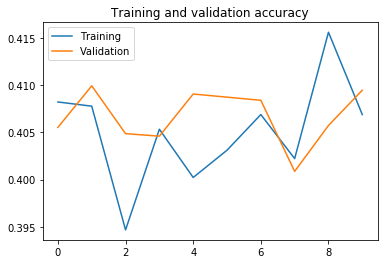

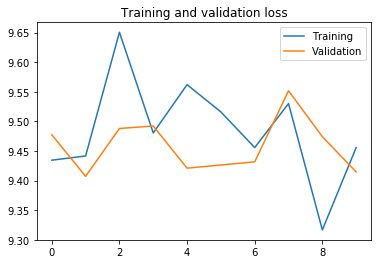

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#DenseNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.densenet import DenseNet201

predefined_model = DenseNet201(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 106, 106, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6398$ | | $Loss_{val} = 9.5612$ |  |$Accuracy_{train} = 0.3953$ | |  $Accuracy_{val} = 0.4003$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 212s 1s/step - loss: 9.5513 - acc: 0.4009 - val_loss: 9.4358 - val_acc: 0.4081
Epoch 2/10
150/150 [==============================] - 139s 926ms/step - loss: 9.4627 - acc: 0.4064 - val_loss: 9.3401 - val_acc: 0.4141
Epoch 3/10
150/150 [==============================] - 139s 927ms/step - loss: 9.4769 - acc: 0.4056 - val_loss: 9.5038 - val_acc: 0.4039
Epoch 4/10
150/150 [==============================] - 139s 929ms/step - loss: 9.5229 - acc: 0.4027 - val_loss: 9.5824 - val_acc: 0.3989
Epoch 5/10
150/150 [==============================] - 140s 932ms/step - loss: 9.2395 - acc: 0.4204 - val_loss: 9.4933 - val_acc: 0.4045
Epoch 6/10
150/150 [==============================] - 139s 927ms/step - loss: 9.5548 - acc: 0.4007 - val_loss: 9.4602 - val_acc: 0.4066
Epoch 7/10
150/150 [==============================] - 139s 928ms/step - loss: 9.6505 - acc: 0.3947 - val_loss: 9.4421 - val_acc: 0.4077
Epoch 8/10
150/150 [==============================]

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6398$ | | $Loss_{val} = 9.5612$ |  |$Accuracy_{train} = 0.3953$ | |  $Accuracy_{val} = 0.4003$


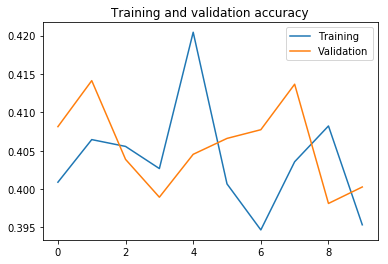

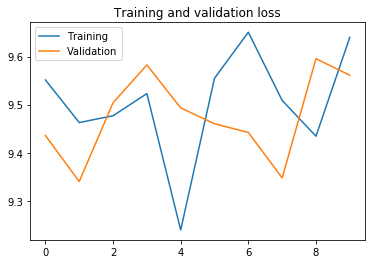

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#NASNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.nasnet import NASNetMobile

predefined_model = NASNetMobile(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 49, 49, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 49, 49, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_595 (Activation)     (None, 49, 49, 32)   0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3918$ | | $Loss_{val} = 9.4326$ |  |$Accuracy_{train} = 0.4109$ | |  $Accuracy_{val} = 0.4083$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 172s 1s/step - loss: 9.5371 - acc: 0.4018 - val_loss: 9.5410 - val_acc: 0.4015
Epoch 2/10
150/150 [==============================] - 93s 621ms/step - loss: 9.3281 - acc: 0.4149 - val_loss: 9.3826 - val_acc: 0.4115
Epoch 3/10
150/150 [==============================] - 94s 630ms/step - loss: 9.4166 - acc: 0.4093 - val_loss: 9.4847 - val_acc: 0.4051
Epoch 4/10
150/150 [==============================] - 100s 664ms/step - loss: 9.4343 - acc: 0.4082 - val_loss: 9.4219 - val_acc: 0.4090
Epoch 5/10
150/150 [==============================] - 94s 627ms/step - loss: 9.3777 - acc: 0.4118 - val_loss: 9.5646 - val_acc: 0.4001
Epoch 6/10
150/150 [==============================] - 92s 616ms/step - loss: 9.4450 - acc: 0.4076 - val_loss: 9.4581 - val_acc: 0.4067
Epoch 7/10
150/150 [==============================] - 96s 639ms/step - loss: 9.5265 - acc: 0.4024 - val_loss: 9.5293 - val_acc: 0.4023
Epoch 8/10
150/150 [==============================] - 98

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3918$ | | $Loss_{val} = 9.4326$ |  |$Accuracy_{train} = 0.4109$ | |  $Accuracy_{val} = 0.4083$


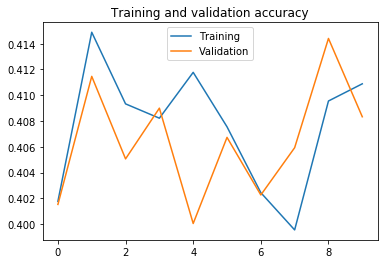

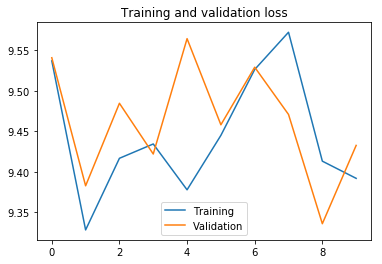

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#Xception (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.xception import Xception

predefined_model = Xception(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_19[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3245$ | | $Loss_{val} = 9.4177$ |  |$Accuracy_{train} = 0.4151$ | |  $Accuracy_{val} = 0.4093$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 156s 1s/step - loss: 9.4733 - acc: 0.4058 - val_loss: 9.4623 - val_acc: 0.4065
Epoch 2/10
150/150 [==============================] - 99s 661ms/step - loss: 9.5477 - acc: 0.4011 - val_loss: 9.4772 - val_acc: 0.4055
Epoch 3/10
150/150 [==============================] - 98s 656ms/step - loss: 9.4131 - acc: 0.4096 - val_loss: 9.4900 - val_acc: 0.4047
Epoch 4/10
150/150 [==============================] - 99s 661ms/step - loss: 9.4591 - acc: 0.4067 - val_loss: 9.4932 - val_acc: 0.4045
Epoch 5/10
150/150 [==============================] - 100s 667ms/step - loss: 9.5583 - acc: 0.4004 - val_loss: 9.3975 - val_acc: 0.4105
Epoch 6/10
150/150 [==============================] - 99s 661ms/step - loss: 9.6292 - acc: 0.3960 - val_loss: 9.4602 - val_acc: 0.4066
Epoch 7/10
150/150 [==============================] - 99s 662ms/step - loss: 9.3529 - acc: 0.4133 - val_loss: 9.4804 - val_acc: 0.4053
Epoch 8/10
150/150 [==============================] - 94

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3245$ | | $Loss_{val} = 9.4177$ |  |$Accuracy_{train} = 0.4151$ | |  $Accuracy_{val} = 0.4093$


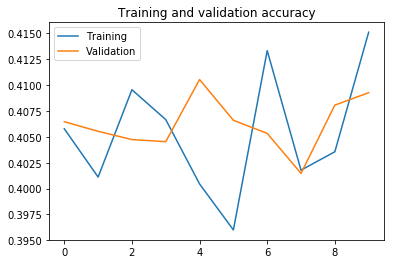

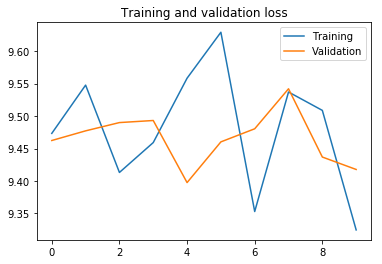

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model